# TreeDLib

In [256]:
%load_ext autoreload
%autoreload 2
%load_ext sql
#from treedlib import *
# Note: reloading for submodules doesn't work, so we load directly here
from treedlib.util import *
from treedlib.structs import *
from treedlib.templates import *
from treedlib.features import *
import lxml.etree as et
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The sql extension is already loaded. To reload it, use:
  %reload_ext sql


We define three classes of operators:
* _NodeSets:_ $S : 2^T \mapsto 2^T$
* _Indicators:_ $I : 2^T \mapsto \{0,1\}^F$
* _Combinators:_ $C : \{0,1\}^F \times \{0,1\}^F \mapsto \{0,1\}^F$

where $T$ is a given input tree, and $F$ is the dimension of the feature space.

## Binning

In [118]:
%sql postgresql://ajratner@localhost:6432/genomics_ajratner2
res_seq = %sql SELECT * FROM genepheno_features WHERE feature LIKE '%SEQ%'
res_dep = %sql SELECT * FROM genepheno_features WHERE feature NOT LIKE '%SEQ%'

1135680 rows affected.
1124224 rows affected.


[5.0, 8.0, 14.0]


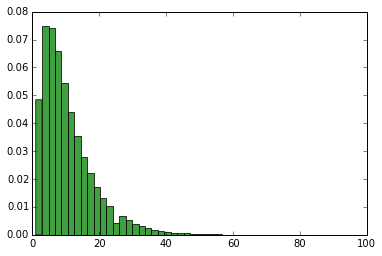

In [138]:
%matplotlib inline
import matplotlib.pyplot as plt

seq_lens = [len(rs.feature.split('_')) for rs in res_seq]
n, bins, patches = plt.hist(seq_lens, 50, normed=1, facecolor='green', alpha=0.75)
print [np.percentile(seq_lens, p) for p in [25,50,75]]

[3.0, 4.0, 6.0]


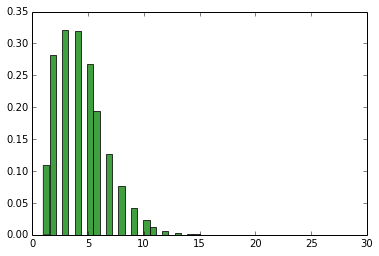

In [139]:
n, bins, patches = plt.hist(dep_lens, 50, normed=1, facecolor='green', alpha=0.75)
dep_lens = [len(rs.feature.split('_')) for rs in res_dep]
print [np.percentile(dep_lens, p) for p in [25,50,75]]

## Adding new feature types...

In [253]:
cids = [gidxs, pidxs]
xt.render_tree(highlight=cids)

<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 TFB1M has been identified as a nuclear modifier of the 1555A > G mutation in the 12S rRNA gene that causes nonsyndromic or aminoglycoside antibiotic-induced deafness -LRB- -RRB- .

In [257]:
ds = {'GENE': ['TFB1M']}
gen_feats = compile_relation_feature_generator()

In [258]:
for f in gen_feats(xt.root, gidxs, pidxs):
    print f

LEMMA:BETWEEN-MENTION-and-MENTION[identify mutation gene cause]
DEP_LABEL:BETWEEN-MENTION-and-MENTION[ prep_as prep_in rcmod]
DEP_LABEL|LEMMA:BETWEEN-MENTION-and-MENTION[|identify prep_as|mutation prep_in|gene rcmod|cause]
LEMMA:PARENTS-OF-BETWEEN-MENTION-and-MENTION[None]
LEMMA:BETWEEN-MENTION-and-MENTION[identify mutation]
LEMMA:BETWEEN-MENTION-and-MENTION[mutation gene]
LEMMA:BETWEEN-MENTION-and-MENTION[gene cause]
LEMMA:BETWEEN-MENTION-and-MENTION[identify mutation gene]
LEMMA:BETWEEN-MENTION-and-MENTION[mutation gene cause]
DEP_LABEL:BETWEEN-MENTION-and-MENTION[ prep_as]
DEP_LABEL:BETWEEN-MENTION-and-MENTION[prep_as prep_in]
DEP_LABEL:BETWEEN-MENTION-and-MENTION[prep_in rcmod]
DEP_LABEL:BETWEEN-MENTION-and-MENTION[ prep_as prep_in]
DEP_LABEL:BETWEEN-MENTION-and-MENTION[prep_as prep_in rcmod]
DEP_LABEL|LEMMA:BETWEEN-MENTION-and-MENTION[|identify prep_as|mutation]
DEP_LABEL|LEMMA:BETWEEN-MENTION-and-MENTION[prep_as|mutation prep_in|gene]
DEP_LABEL|LEMMA:BETWEEN-MENTION-and-MENTION[p

# Genomics Debugging Pipeline

* Fix this!
* _Features to add:_
    * modifiers of VBs in between
    * candidates in between?
    * Better way to do siblings, when siblings have children...?
        * LeftAll / RightAll
        * Also, get unigrams, etc.
        * **Use wildcard, e.g. "ABC now causes" --> WORD:LEFT-OF-MENTION[?_causes]**?
    * Modifiers before e.g. "We investigated whether..." / NEGATIONS (see Johannes's email / list)
    * Handle negation words explicitly?

In [4]:
from random import shuffle
RESULTS_ROOT = '/lfs/raiders7/hdd/ajratner/dd-genomics/alex-results/'
def get_exs(header, rel_path, root=RESULTS_ROOT):
    rids = []
    in_section = False
    with open(root + rel_path, 'rb') as f:
        for line in f:
            if in_section and len(line.strip()) == 0:
                break
            elif in_section:
                rids.append('_'.join(map(lambda x : x[0].upper() + x[1:], line.strip().split('_'))))
            elif line.strip() == header:
                in_section = True
    return rids

In [17]:
false_pos = get_exs('False Positives:', '02-01-16/stats_causation_1500.tsv')
false_negs = get_exs('False Negatives:', '02-01-16/stats_causation_1500.tsv')
#shuffle(false_pos)
#shuffle(false_negs)

In [250]:
#relation_id = false_negs[12]
#print relation_id
relation_id = '20396601_Body.0_287_0_20396601_Body.0_287_25'

In [251]:
# Connect to correct db
%sql postgresql://ajratner@localhost:6432/genomics_ajratner

# Getting the component IDs
id = relation_id.split('_')
doc_id = id[0]
section_id = id[1][0].upper() + id[1][1:]
sent_id = int(id[2])
gidxs = map(int, relation_id.split(doc_id)[1].strip('_').split('_')[-1].split('-'))
pidxs = map(int, relation_id.split(doc_id)[2].strip('_').split('_')[-1].split('-'))
cids = [gidxs, pidxs]

# Get sentence from db + convert to XMLTree
res = %sql SELECT words, lemmas, poses, ners, dep_paths AS "dep_labels", dep_parents FROM sentences_input WHERE doc_id = :doc_id AND section_id = :section_id AND sent_id = :sent_id;
rows = [dict((k, v.split('|^|')) for k,v in dict(row).iteritems()) for row in res]
xts = map(corenlp_to_xmltree, rows)
xt = xts[0]

# Show XMLTree
xt.render_tree(highlight=[gidxs, pidxs])

# Print TreeDLib features
#print_gen(get_relation_features(xt.root, gidxs, pidxs))

1 rows affected.


<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 TFB1M has been identified as a nuclear modifier of the 1555A > G mutation in the 12S rRNA gene that causes nonsyndromic or aminoglycoside antibiotic-induced deafness -LRB- -RRB- .

In [52]:
Ngrams(Children(Filter(Between(Mention(0), Mention(1)), 'pos', 'VB')), 'word', 1).print_apply(xt.root, cids)

INV_WORD:CHILDREN-OF-FILTER-BY(pos=VB):BETWEEN-MENTION-and-MENTION[movement]
INV_WORD:CHILDREN-OF-FILTER-BY(pos=VB):BETWEEN-MENTION-and-MENTION[has]
INV_WORD:CHILDREN-OF-FILTER-BY(pos=VB):BETWEEN-MENTION-and-MENTION[been]
INV_WORD:CHILDREN-OF-FILTER-BY(pos=VB):BETWEEN-MENTION-and-MENTION[fibers]
INV_WORD:CHILDREN-OF-FILTER-BY(pos=VB):BETWEEN-MENTION-and-MENTION[heterozygous]


## Error analysis round 4

### False negatives:
* [0] `24065538_Abstract.0_2_8_24065538_Abstract.0_2_14`:
    * **Should this be association instead?**
    * "... have been found... however studies of the association between ... and OSA risk have reported inconsistent findings"

* [1] `8844207_Abstract.0_5_6_8844207_Abstract.0_5_1`:
    * **"known {{G}} mutations"**

* [2] `24993959_Abstract.1_3_36_24993959_Abstract.1_3_46`:
    * `UnicodeDecodeError`!
    
* [3] `22653594_Abstract.0_1_5_22653594_Abstract.0_1_25-26-27`:
    * **Incorrectly labeled**
    
* [4] `21282350_Abstract.0_1_13_21282350_Abstract.0_1_20`:
    * `UnicodeDecodeError`!

* [5] `11461952_Abstract.0_10_8_11461952_Abstract.0_10_15-16`:
    * "This study deomstrates that ... can be responsible for ..."
    * "{{G}} responsible for {{P}}"
    
* [6] `25110572_Body.0_103_42_25110572_Body.0_103_18-19`:
    * **Incorrectly labeled??**
    
* [7] `22848613_Body.0_191_7_22848613_Body.0_191_15`:
    * **Incorrectly labeled??**

* [8] `19016241_Abstract.0_2_29_19016241_Abstract.0_2_34-35`:
    * **Incorrectly labeled??**
    * "weakly penetrant"
    
* [9] `19877056_Abstract.0_2_37_19877056_Abstract.0_2_7`:
    * **"{{P}} attributable to {{G}}"**

* [10] `11079449_Abstract.0_5_48_11079449_Abstract.0_5_41`:
    * **_Tough example: ref to a list of pairs!_**

* [11] `11667976_Body.0_6_31_11667976_Body.0_6_34-35`:
    * **Is this correctly labeled...?**

* [12] `11353725_Abstract.0_7_13_11353725_Abstract.0_7_9`:
    * **Is this correctly labeled...?**

* [13] `20499351_Body.0_120_6_20499351_Body.0_120_10-11-12`:
    * "Patients homozygous for {{g}} mutation had"
    * "had" on path between
    
* [14] `10511432_Abstract.0_1_12_10511432_Abstract.0_1_23`:
    * **Incorrectly labeled...??**
    
* [15] `17033686_Abstract.0_4_4_17033686_Abstract.0_4_12`:
    * "misense mutation in {{G}} was described in a family with {{P}}"
    * **_Incorrectly labeled...?_**

* [16] `23288328_Body.0_179_20_23288328_Body.0_179_24-25`:
    * **{{G}} - related {{P}}**

* [17] `21203343_Body.0_127_4_21203343_Body.0_127_19`:
    * "have been reported in"- **Incorrectly labeled?**

* [18] `9832037_Abstract.0_2_13_9832037_Abstract.0_2_26-27-28`:
    * "{{G}} sympotms include {{P}}", "include"

* [19] `18791638_Body.0_8_6_18791638_Body.0_8_0`:
    * "{{P}} results from {{G}}"

In [ ]:
%%sql
-- Get the features + weights for an example
SELECT f.feature, w.weight
FROM
    genepheno_features f,
    dd_inference_result_variables_mapped_weights w
WHERE
    f.relation_id = :relation_id
    AND w.description = 'inf_istrue_genepheno_causation_inference--' || f.feature
ORDER BY w.weight DESC;

In [48]:
res = _
sum(r[1] for r in res)

0.6422394999999999

In [49]:
%sql SELECT expectation FROM genepheno_causation_inference_label_inference WHERE relation_id = :relation_id;

1 rows affected.


expectation
0.662


## Error analysis round 3

### False Positives:
* [0] `18478198_Abstract.0_2_29_18478198_Abstract.0_2_11-12`:
    * "our aim was to establish whether"

* [1] `17508172_Abstract.0_4_21_17508172_Abstract.0_4_32`:
    * "role"
    * "sodium ion channel"
    
* [2] `19561293_Abstract.0_3_7_19561293_Abstract.0_3_10-11`:
    * "are currently unknown"

* [3] `19956409_Abstract.0_1_8_19956409_Abstract.0_1_21`:
    * r'^To evaluate'
    * "the possible role"
    
* [4] `19714249_Body.0_130_10_19714249_Body.0_130_18`:
    * '^Although"
    * "potential role"
    * "needs to be replicated"
    * "suggests", "possible", "role"
    
* [5] `16297188_Title.0_1_5_16297188_Title.0_1_14`:
    * "role"
    * **Incorrectly supervised...?**
    
* [6] `24412566_Body.0_70_72_24412566_Body.0_70_6`:
    * **_Long one with other genes in between..._**

* [7] `16837472_Abstract.3_1_19_16837472_Abstract.3_1_10`:
    * "needs to be further studied"
    * "associated"

* [8] `14966353_Abstract.0_1_41_14966353_Abstract.0_1_5`:
    * `UnicodeError`!

* [9] `15547491_Abstract.0_1_23_15547491_Abstract.0_1_7-8-9-10`:
    * r'^To analyze'

## Error analysis round 2

With new DSR code:

### False Positives
* [0] `17183713_Body.0_111_12_17183713_Body.0_111_25`:
    * **"unlikely" on path between**

* [1] `19561293_Abstract.0_3_7_19561293_Abstract.0_3_10-11`:
    * _"are unknown"- not on dep path between..._
    * **Labeling error- doesn't this imply that there is a causal relation??**

* [2] `17167409_Abstract.3_2_5_17167409_Abstract.3_2_13`:
    * **"is _not_ a common cause of..." - NEG modifying primary VB on path between!!!**
    
* [3] `18538017_Body.0_12_5_18538017_Body.0_12_17`:
    * **Labeling error!? (marked because only partial P...?)**

* [4] `20437121_Abstract.0_1_30_20437121_Abstract.0_1_15`:
    * "to determine" - in phrase between
    
* [5] `10435725_Abstract.0_1_14_10435725_Abstract.0_1_20`:
    * "in mice" - off the main VB
    
* [6] `23525542_Abstract.0_7_12_23525542_Abstract.0_7_24`:
    * **is _not_ due to..."- NEG modifying primary VB on path between!!!**

* [7] `19995275_Abstract.0_1_2_19995275_Abstract.0_1_18`:
    * "has been implicated... in various studies with conflicting results"

### False Negatives
* [0] `23874215_Body.0_172_3_23874215_Body.0_172_23-24-25-26`:
    * "role", "detected" - dep path between

* [1] `17507029_Abstract.0_2_13_17507029_Abstract.0_2_6-7-8-9-10`:
    * "caused by" but also "association"... should do dep path in between...?
    * _a tough one..._

* [2] `15219231_Body.0_121_8_15219231_Body.0_121_35`:
    * **Incorrect label**
    
* [3] `25110572_Body.0_103_42_25110572_Body.0_103_18-19`:
    * **Incorrect label- should be association?**
    
* [4] `17909190_Abstract.0_3_16_17909190_Abstract.0_3_25`:
    * **Incorrectly labeled...?**
    
* [5] `22803640_Abstract.0_3_14_22803640_Abstract.0_3_24-25`:
    * **Incorrectly labeled- should be association?**
    
* [6] `11170071_Abstract.0_1_3_11170071_Abstract.0_1_21`:
    * **Incorrectly labeled- wrong mention**
    
* [7] `10511432_Abstract.0_1_12_10511432_Abstract.0_1_23`:
    * "A variety of mutations have been detected in patients with..."- should this be association?
    
* [8] `10797440_Abstract.0_3_16_10797440_Abstract.0_3_3`:
    * _This one seems like should be straight-forwards..._
    * **{{P}} are due to {{G}}**

* [9] `23275784_Body.0_82_29_23275784_Body.0_82_13`:
    * _This one seems like should be straight-forwards..._
    * **{{P}} result of / due to mutations in {{G}}**

In [ ]:
# Filler

### To investigate:
1. Correlation with length of sentence? - **_No._**
2. Low-MI words like '\_', 'the', 'gene'?
3. _[tdl] Include sequence patterns too?_

### FNs / recall analysis notes

* `10982191_Title.0_1_8_10982191_Title.0_1_21-22-23`:
    * Shorter sentence
    * neg. weight from "gene" in between... is this just super common?

* `19353431_Abstract.0_2_12_19353431_Abstract.0_2_1`:
    * Shorter sentence
    * neg. weight from "gene" in between... is this just super common?

* `23285148_Body.0_4_32_23285148_Body.0_4_3`:
    * **Incorrectly labeled: should be false**

* `23316347_Body.0_202_25_23316347_Body.0_202_54`:
    * _Longer sentence..._
    * **BUG: Missing a left-of-mention (G: "mutation")!**
    * neg. weight from "\_" in betweeen
    * **BUG: left-of-mention[delay] happens twice!**
    * A lot of negative weight from "result"...?
    
* `21304894_Body.0_110_4_21304894_Body.0_110_9-10-11`:
    * Shorter sentence
    * A lot of negative weight from "result"...?
        * **Is this just from a low-quality DSR?**
    * Duplicated features again!
    
* `21776272_Body.0_60_46_21776272_Body.0_60_39-40`:
    * Longer sentence
    * A slightly tougher example: an inherited disorder ... with mutations in gene...
    * neg. weight from "gene" in between... is this just super common?

* `19220582_Abstract.0_2_20_19220582_Abstract.0_2_5`:
    * 'We identified a mutation in a family with...' - should this be a positive example??
    * neg. weight from "gene" in between... is this just super common?
    * neg. weight from "identify" and "affect"...?
    * **'c. mutation' - mutation doesn't get picked up as it's a child off the path...**

* `23456818_Body.0_148_9_23456818_Body.0_148_21-22`:
    * `LEMMA:PARENTS-OF-BETWEEN-MENTION-and-MENTION[determine]` has huge negative weight
    * gene, patient, distribution, etc. - neg weight
    * negative impact from `PARENTS OF`...

* `20429427_Abstract.0_1_2_20429427_Abstract.0_1_14`:
    * **Key word like "mutation" is off main path... ("responsible -> mutation -> whose")**
    * **STOPWORDS: "the"**
    * **BUG: dep_path labels are all None...**, **BUG: left-siblings doubled**

* `21031598_Body.0_24_25_21031598_Body.0_24_9`:
    * Need a feature like `direct parent of mention`
    * NEG: 'site', 'gene'
    * `INV_`

* `22670894_Title.0_1_16_22670894_Title.0_1_7-8`:
    * NEG: 'the', 'gene', 'locus'
    * **'due to' just dropped from the dep tree!**

* `22887726_Abstract.0_5_33_22887726_Abstract.0_5_54-55`:
    * **Incorrectly labeled for causation?**

* `19641605_Abstract.0_3_14_19641605_Abstract.0_3_22`:
    * This one has "cause", exp = 0.89, seems like dead match...
    * **BUG: doubles of stuff!!!!!**

* `23879989_Abstract.0_1_3_23879989_Abstract.0_1_12-13`:
    * This one has "cause", exp = 0.87, seems like dead match...
    * **BUG: doubles of stuff!!!!!**
    * `LEMMA:FILTER-BY(pos=NN):BETWEEN-MENTION-and-MENTION[_]`
    * 'distinct', 'mutation _ cause'...
        * **_Why does '\_' have such negative weight??_**

* `21850180_Body.0_62_14_21850180_Body.0_62_26-27`:
    * This one again seems like should be a dead match...
    * **BUG: Double of word "three"!**
    * Key word "responsible" not included...?
    * NEG: 'identify', 'i.e.', '_ _ _'

* `20683840_Abstract.0_4_12_20683840_Abstract.0_4_33`:
    * UnicodeError!

* `17495019_Title.0_1_5_17495019_Title.0_1_18`:
    * **Incorrectly labeled for causation?**
    * _Why is '% patients' positive...?_

* `18283249_Abstract.0_3_2_18283249_Abstract.0_3_16-17-18`:
    * **'are one of the factors' - is this correctly labeled for causation?**

* `21203343_Body.0_10_3_21203343_Body.0_10_20`:
    * **'are described in...' - this at least seems on the border of "causation"**
    * expectation 0.85
    * **BUG: doubles**
    * NEG: `_`

* `24312213_Body.0_110_66_24312213_Body.0_110_73`:
    * **Interesting example of isolated subtree which should be direct match!**
    * Expectation 0.42???
    * NEG: 'mutation result', `_`, 'result', 'influence'

### Final tally:
* 55%: Negative weight from features that seem like they should be stop words
* 25%: Incorrectly labeled or on the border
* 40%: Bug of some sort in TreeDLib
* 30%: Features that seems suprisingly weighted- due to low-quality DSRs?

## TODO:
1. Fix bugs in treedlib - DONE
2. Filter "stopwords" i.e. low-Chi-squared features - DONE
3. Add manual weights to DSRs in `config.py`

## Testing the low-Chi-squared hypothesis

In [249]:
%sql SELECT COUNT(*) FROM genepheno_features;

1 rows affected.


count
63704195


In [250]:
%sql SELECT COUNT(DISTINCT(feature)) FROM genepheno_features;

1 rows affected.


count
12054299


In [247]:
%%sql
SELECT
    gc.is_correct, COUNT(*)
FROM
    genepheno_causation gc,
    genepheno_features gf
WHERE
    gc.relation_id = gf.relation_id
    AND gf.feature LIKE '%the%'
GROUP BY
    gc.is_correct;

3 rows affected.


is_correct,count
False,89341
None,207757
True,23651


In [248]:
%sql SELECT is_correct, COUNT(*) FROM genepheno_causation GROUP BY is_correct;

3 rows affected.


is_correct,count
False,116608
True,40022
None,307806


In [259]:
P_T = 40022.0/(116608.0+40022.0)
P_F = 116608.0/(116608.0+40022.0)
print P_T
print P_F

0.255519376875
0.744480623125


In [257]:
from collections import defaultdict
feats = defaultdict(lambda : [0,0])
with open('/lfs/raiders7/hdd/ajratner/dd-genomics/alex-results/chi-sq/chi-sq-gp.tsv', 'rb') as f:
    for line in f:
        feat, label, count = line.split('\t')
        b = 0 if label == 't' else 1
        feats[feat][b] = int(count)

In [258]:
feats['INV_DEP_LABEL:BETWEEN-MENTION-and-MENTION[nsubj_vmod_prepc_by]']

[4, 1]

In [273]:
chi_sqs = []
for feat, counts in feats.iteritems():
    total = float(counts[0] + counts[1])
    chi_sqs.append([
        (P_T-(counts[0]/total))**2 + (P_F-(counts[1]/total))**2,
        feat
    ])
chi_sqs.sort()

In [283]:
with open('/lfs/raiders7/hdd/ajratner/dd-genomics/alex-results/chi-sq/chi-sq-gp-computed.tsv', 'wb') as f:
    for x in chi_sqs:
        f.write('\t'.join(map(str, x[::-1]))+'\n')

In [277]:
len(chi_sqs)

1561184

In [299]:
chi_sqs[500000]

[0.13058030391762518,
 'INV_DEP_LABEL|LEMMA:BETWEEN-MENTION-and-MENTION[prep_of|__vmod|associate]']

In [274]:
thes = filter(lambda x : 'the' in x[1], chi_sqs)

In [275]:
len(thes)

33304

In [276]:
thes[:100]

[[1.5873326911132163e-06, 'LEMMA:LEFT-OF-MENTION[the_mutation]'],
 [3.062217941380416e-06, 'LEMMA:PARENTS-OF-BETWEEN-MENTION-and-MENTION[the]'],
 [6.092704218625953e-05,
  'DEP_LABEL:BETWEEN-MENTION-and-MENTION[prep_in_prep_together_with]'],
 [6.092704218625953e-05,
  'DEP_LABEL:BETWEEN-MENTION-and-MENTION[prep_together_with_prep_on]'],
 [6.092704218625953e-05,
  'DEP_LABEL|LEMMA:BETWEEN-MENTION-and-MENTION[dobj|hypothesis_dep|associate]'],
 [6.092704218625953e-05,
  'INV_LEMMA:BETWEEN-MENTION-and-MENTION[further_confirm]'],
 [6.092704218625953e-05,
  'INV_LEMMA:FILTER-BY(pos=NN):BETWEEN-MENTION-and-MENTION[brother]'],
 [6.092704218625953e-05, 'INV_LEMMA:LEFT-OF-MENTION[either_a]'],
 [6.092704218625953e-05, 'INV_LEMMA:LEFT-OF-MENTION[molecular_the]'],
 [6.092704218625953e-05, 'INV_LEMMA:LEFT-OF-MENTION[only_the]'],
 [6.092704218625953e-05, 'INV_LEMMA:LEFT-OF-MENTION[the_biochemical]'],
 [6.092704218625953e-05, 'INV_LEMMA:LEFT-OF-MENTION[the_describe]'],
 [6.092704218625953e-05, 'INV_LE

## Testing the length-bias hypothesis

Is their a bias towards longer sentences (because more high-weight keywords?)

In [107]:
rows = []
with open('/lfs/raiders7/hdd/ajratner/dd-genomics/alex-results/test-len-corr/all_rel_sents.tsv', 'rb') as f:
    for line in f:
        r = line.rstrip().split('\t')
        rows.append([float(r[1]), len(r[2].split('|^|'))])
print len(rows)

464446


In [111]:
from scipy.stats import pearsonr
exps, lens = zip(*filter(lambda r : r[0] > 0.7, rows))
pearsonr(exps, lens)

(0.01490680366497573, 0.00028709107735074691)

In [59]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import random

exps, lens = zip(*random.sample(filter(lambda r : r[0] > 0.5, rows), 1000))
plt.scatter(lens, exps)

KeyError: 0

## Debugging pipeline

We'll debug here, also to show the general most current procedure for debugging treedlib on examples in a SQL database (e.g. from DeepDive)

In [ ]:
%sql postgresql://ajratner@localhost:5432/deepdive_spouse

In [ ]:
%%sql 
SELECT sentence_text
FROM sentences 
WHERE doc_id = '79205745-b593-4b98-8a94-da6b8238fefc' AND sentence_index = 32;

In [ ]:
res = %sql SELECT tokens AS "words", lemmas, pos_tags, ner_tags, dep_types AS "dep_labels", dep_tokens AS "dep_parents" FROM sentences WHERE doc_id = '79205745-b593-4b98-8a94-da6b8238fefc' AND sentence_index = 32;
xts = map(corenlp_to_xmltree, res)

In [ ]:
xt = xts[0]
xt.render_tree(highlight=[[21,22], [33,34]])

In [ ]:
print_gen(get_relation_features(xt.root, [21,22], [33,34]))

## Feature focus: Preceding statements which nullify or negate meaning

Example:
> _Ex1:_ To investigate whether mutations in the SURF1 gene are a cause of Charcot-Marie-Tooth -LRB- CMT -RRB- disease

> _Ex2:_ To investigate the genetic effect of a new mutation found in exon 17 of the myophosphorylase -LRB- PYGM -RRB- gene as a cause of McArdle disease -LRB- also known as type 5 glycogenosis -RRB-.

Notes:
* These seem to mostly be **_modifiers of the primary verb_**?
    * We are only sampling from a limited set of patterns of sentences (due to narrow DSR set) currently...
* Modifiers in general...?
* _I know how RNNs claim to / do handle this phenomenon..._ *

In [43]:
%%sql
SELECT relation_id
FROM genepheno_causation
WHERE doc_id = '15262743' AND section_id = 'Abstract.0' AND sent_id = 1;

0 rows affected.


relation_id


In [ ]:
ex1_id = ('24027061', 'Abstract.0', 1)
ex1_raw="""
<node dep_parent="0" lemma="investigate" ner="O" pos="VB" word="investigate" word_idx="1"><node dep_parent="2" dep_path="aux" lemma="to" ner="O" pos="TO" word="To" word_idx="0"/><node dep_parent="2" dep_path="ccomp" lemma="cause" ner="O" pos="NN" word="cause" word_idx="10"><node dep_parent="11" dep_path="mark" lemma="whether" ner="O" pos="IN" word="whether" word_idx="2"/><node dep_parent="11" dep_path="nsubj" lemma="mutation" ner="O" pos="NNS" word="mutations" word_idx="3"><node dep_parent="4" dep_path="prep_in" lemma="gene" ner="O" pos="NN" word="gene" word_idx="7"><node dep_parent="8" dep_path="det" lemma="the" ner="O" pos="DT" word="the" word_idx="5"/><node dep_parent="8" dep_path="nn" lemma="surf1" ner="O" pos="NN" word="SURF1" word_idx="6"/></node></node><node dep_parent="11" dep_path="cop" lemma="be" ner="O" pos="VBP" word="are" word_idx="8"/><node dep_parent="11" dep_path="det" lemma="a" ner="O" pos="DT" word="a" word_idx="9"/><node dep_parent="11" dep_path="prep_of" lemma="Charcot-Marie-Tooth" ner="O" pos="NNP" word="Charcot-Marie-Tooth" word_idx="12"/><node dep_parent="11" dep_path="dep" lemma="disease" ner="O" pos="NN" word="disease" word_idx="16"><node dep_parent="17" dep_path="appos" lemma="CMT" ner="O" pos="NNP" word="CMT" word_idx="14"/></node></node></node>
"""
xt1 = XMLTree(et.fromstring(ex1_raw))
ex2_id = ('15262743', 'Abstract.0', 1)
ex2_raw="""
<node dep_parent="0" lemma="investigate" ner="O" pos="VB" word="investigate" word_idx="1"><node dep_parent="2" dep_path="aux" lemma="to" ner="O" pos="TO" word="To" word_idx="0"/><node dep_parent="2" dep_path="dobj" lemma="effect" ner="O" pos="NN" word="effect" word_idx="4"><node dep_parent="5" dep_path="det" lemma="the" ner="O" pos="DT" word="the" word_idx="2"/><node dep_parent="5" dep_path="amod" lemma="genetic" ner="O" pos="JJ" word="genetic" word_idx="3"/><node dep_parent="5" dep_path="prep_of" lemma="mutation" ner="O" pos="NN" word="mutation" word_idx="8"><node dep_parent="9" dep_path="det" lemma="a" ner="O" pos="DT" word="a" word_idx="6"/><node dep_parent="9" dep_path="amod" lemma="new" ner="O" pos="JJ" word="new" word_idx="7"/><node dep_parent="9" dep_path="vmod" lemma="find" ner="O" pos="VBN" word="found" word_idx="9"><node dep_parent="10" dep_path="prep_in" lemma="exon" ner="O" pos="NN" word="exon" word_idx="11"><node dep_parent="12" dep_path="num" lemma="17" ner="NUMBER" pos="CD" word="17" word_idx="12"/><node dep_parent="12" dep_path="prep_of" lemma="gene" ner="O" pos="NN" word="gene" word_idx="19"><node dep_parent="20" dep_path="det" lemma="the" ner="O" pos="DT" word="the" word_idx="14"/><node dep_parent="20" dep_path="nn" lemma="myophosphorylase" ner="O" pos="NN" word="myophosphorylase" word_idx="15"/><node dep_parent="20" dep_path="nn" lemma="pygm" ner="O" pos="NN" word="PYGM" word_idx="17"/></node></node><node dep_parent="10" dep_path="prep_as" lemma="cause" ner="O" pos="NN" word="cause" word_idx="22"><node dep_parent="23" dep_path="det" lemma="a" ner="O" pos="DT" word="a" word_idx="21"/><node dep_parent="23" dep_path="prep_of" lemma="disease" ner="O" pos="NN" word="disease" word_idx="25"><node dep_parent="26" dep_path="nn" lemma="McArdle" ner="PERSON" pos="NNP" word="McArdle" word_idx="24"/><node dep_parent="26" dep_path="vmod" lemma="know" ner="O" pos="VBN" word="known" word_idx="28"><node dep_parent="29" dep_path="advmod" lemma="also" ner="O" pos="RB" word="also" word_idx="27"/><node dep_parent="29" dep_path="prep_as" lemma="glycogenosis" ner="O" pos="NN" word="glycogenosis" word_idx="32"><node dep_parent="33" dep_path="nn" lemma="type" ner="O" pos="NN" word="type" word_idx="30"/><node dep_parent="33" dep_path="num" lemma="5" ner="NUMBER" pos="CD" word="5" word_idx="31"/></node></node></node></node></node></node></node></node>
"""
xt2 = XMLTree(et.fromstring(ex2_raw))

In [ ]:
xt1.render_tree()
xt2.render_tree()

### Testing XML speeds

How does it compare between:
* parse to XML via this python code, store as string, then parse from string at runtime
* just parse to XML at runtime via this python code?

In [ ]:
# Map sentence to xmltree
%time xts = map(corenlp_to_xmltree, rows)

In [ ]:
# Pre-process to xml string
xmls = [xt.to_str() for xt in map(corenlp_to_xmltree, rows)]

# Parse @ runtime using lxml
%time roots = map(et.fromstring, xmls)

### Table example

In [ ]:
# Some wishful thinking...
table_xml = """
<div class="table-wrapper">
    <h3>Causal genomic relationships</h3>
    <table>
        <tr><th>Gene</th><th>Variant</th><th>Phenotype</th></tr>
        <tr><td>ABC</td><td><i>AG34</i></td><td>Headaches during defecation</td></tr>
        <tr><td>BDF</td><td><i>CT2</i></td><td>Defecation during headaches</td></tr>
        <tr><td>XYG</td><td><i>AT456</i></td><td>Defecasomnia</td></tr>
    </table>
</div>
"""
from IPython.core.display import display_html, HTML
display_html(HTML(table_xml))